# Two-Stage Traffic Flow Batch Inference
## Stage 1: Predict Visitors & Vehicles from Weather
## Stage 2: Predict Traffic Flow using Stage 1 predictions

## 1. Environment Setup

In [20]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    if root_dir.parts[-1:] == ('traffic_flow',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
from mlfs import config
# settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /mnt/d/deskkk/kth documents/ID2223/project


In [21]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
import matplotlib.pyplot as plt

## 2. Connect to Hopsworks

In [22]:
# Connect to Hopsworks - REPLACE WITH YOUR API KEY
project = hopsworks.login(api_key_value='DySYOV5ksYlcstw4.NNQmxxhxC9OIq4PtZraWxsiRZhu00i7SlsBHaviCX2mrEtQILdEVCtUES2zeV8Gp')
fs = project.get_feature_store()

2026-01-12 00:02:07,542 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-12 00:02:07,551 INFO: Initializing external client
2026-01-12 00:02:07,552 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-12 00:02:08,164 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-12 00:02:09,151 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1329301


## 3. Load All Three Models

In [23]:
print("=== Loading Models from Model Registry ===")
mr = project.get_model_registry()

# Model 1: Visitors prediction (Weather + Holidays → Visitors)
model_visitors_meta = mr.get_model(
    name="traffic_flow_visitors_xgboost_model",  # 修改为你的模型名
    version=4,  # 修改为你的版本
)
saved_dir_visitors = model_visitors_meta.download()
model_visitors = XGBRegressor()
model_visitors.load_model(saved_dir_visitors + "/model.json")
print("✓ Visitors prediction model loaded")

# Model 2: Vehicles prediction (Weather + Holidays → Vehicles)
model_vehicles_meta = mr.get_model(
    name="traffic_flow_vehicles_xgboost_model",  # 修改为你的模型名
    version=4,  # 修改为你的版本
)
saved_dir_vehicles = model_vehicles_meta.download()
model_vehicles = XGBRegressor()
model_vehicles.load_model(saved_dir_vehicles + "/model.json")
print("✓ Vehicles prediction model loaded")

# Model 3: Traffic flow prediction (Weather + Holidays + Visitors + Vehicles → Traffic)
model_traffic_meta = mr.get_model(
    name="traffic_flow_xgboost_model",  # 修改为你的模型名
    version=7,  # 修改为你的版本
)
saved_dir_traffic = model_traffic_meta.download()
model_traffic = XGBRegressor()
model_traffic.load_model(saved_dir_traffic + "/model.json")
print("✓ Traffic flow prediction model loaded")

print("\n✅ All models loaded successfully!")

=== Loading Models from Model Registry ===


Downloading: 0.000%|          | 0/428350 elapsed<00:00 remaining<?

✓ Visitors prediction model loaded, 1 files)... DONE


Downloading: 0.000%|          | 0/432477 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25423 elapsed<00:00 remaining<?

✓ Vehicles prediction model loaded, 2 files)... DONE


Downloading: 0.000%|          | 0/448022 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25807 elapsed<00:00 remaining<?

✓ Traffic flow prediction model loadedfiles)... DONE

✅ All models loaded successfully!


## 4. Get Weather Forecast Data

In [24]:
# Toronto coordinates
city = "Toronto"
latitude = 43.6532
longitude = -79.3832

# Get 7-day weather forecast
print("Fetching weather forecast...")
hourly_df = util.get_hourly_weather_forecast(city, latitude, longitude)

# Convert to daily data (using noon values)
hourly_df = hourly_df.set_index('date')
daily_weather = hourly_df.between_time('11:59', '12:01')
daily_weather = daily_weather.reset_index()

print(f"\n✓ Retrieved {len(daily_weather)} days of weather forecast")
print("\nWeather forecast:")
print(daily_weather)

Fetching weather forecast...
Coordinates 43.75°N -79.5°E
Elevation 99.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

✓ Retrieved 7 days of weather forecast

Weather forecast:
                 date  temperature_2m_mean  precipitation_sum  \
0 2026-01-11 12:00:00               -1.158                0.0   
1 2026-01-12 12:00:00               -1.958                0.0   
2 2026-01-13 12:00:00               -2.458                0.0   
3 2026-01-14 12:00:00                2.242                0.0   
4 2026-01-15 12:00:00              -12.158                0.4   
5 2026-01-16 12:00:00              -19.608                0.0   
6 2026-01-17 12:00:00               -3.958                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  
0           17.935081                   231.519775  
1           16.055355                   227.726364  
2            9.107359                   198.435043  
3           10.829958                   248.552200  
4           20.345573    

## 5. Add Real-time Holiday Information
### Using Python holidays library for accurate, real-time holiday detection

In [25]:
# Install holidays library if not already installed
try:
    import holidays
    print("✓ holidays library already installed")
except ImportError:
    print("Installing holidays library...")
    !pip install holidays
    import holidays
    print("✓ holidays library installed successfully")

✓ holidays library already installed


In [26]:
import holidays
from datetime import datetime
import pandas as pd

# ============================================================
# 第1步：先获取天气数据（这部分你应该已经有了）
# ============================================================
from mlfs.airquality import util

# Toronto coordinates
city = "Toronto"
latitude = 43.6532
longitude = -79.3832

# Get weather forecast
hourly_df = util.get_hourly_weather_forecast(city, latitude, longitude)

# Convert to daily data
hourly_df = hourly_df.set_index('date')
daily_weather = hourly_df.between_time('11:59', '12:01')
daily_weather = daily_weather.reset_index()

# ============================================================
# 第2步：现在可以添加节假日信息了
# ============================================================
# Prepare batch data
batch_data = daily_weather.copy()
batch_data["date"] = pd.to_datetime(batch_data["date"])

print("="*60)
print("Adding Real-time Holiday Information")
print("="*60)

# Create Canada holidays object for Ontario province (Toronto)
ca_holidays = holidays.Canada(prov='ON')

# Custom special dates
special_dates = {
    datetime(2026, 11, 27).date(): 'Black Friday',
    datetime(2026, 12, 24).date(): 'Christmas Eve',
    datetime(2026, 12, 31).date(): 'New Year\'s Eve',
    datetime(2025, 11, 28).date(): 'Black Friday',
    datetime(2025, 12, 24).date(): 'Christmas Eve',
    datetime(2025, 12, 31).date(): 'New Year\'s Eve',
}

# Check if a date is a holiday (包含周末)
def is_holiday(date_obj):
    # 检查周末
    if date_obj.dayofweek >= 5:  # Saturday or Sunday
        return 1
    # Check official holidays
    if date_obj.date() in ca_holidays:
        return 1
    # Check special dates
    if date_obj.date() in special_dates:
        return 1
    return 0

def get_holiday_name(date_obj):
    # 周末名称
    if date_obj.dayofweek == 5:
        return 'Saturday'
    elif date_obj.dayofweek == 6:
        return 'Sunday'
    # 官方节假日
    if date_obj.date() in ca_holidays:
        return ca_holidays.get(date_obj.date())
    if date_obj.date() in special_dates:
        return special_dates[date_obj.date()]
    return ''

# Apply to batch data
batch_data['holidays'] = batch_data['date'].apply(is_holiday)
batch_data['holiday_name'] = batch_data['date'].apply(get_holiday_name)

print(f"\n✓ Holiday information added for {len(batch_data)} days")

# Show holiday details
holiday_rows = batch_data[batch_data['holidays'] == 1]
if len(holiday_rows) > 0:
    print("\n📅 Holidays found in forecast period:")
    for idx, row in holiday_rows.iterrows():
        print(f"   {row['date'].strftime('%Y-%m-%d')}: {row['holiday_name']}")
else:
    print("\n📅 No holidays in the forecast period")

print("\n" + "="*60)
print("Batch data with real-time holidays:")
print("="*60)
display_cols = ['date', 'holidays', 'holiday_name', 'temperature_2m_mean']
print(batch_data[display_cols])

Coordinates 43.75°N -79.5°E
Elevation 99.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Adding Real-time Holiday Information
2026-01-12 00:02:18,681 WARNING: DeprecationWarning: Arguments prov and state are deprecated, use subdiv='ON' instead.


✓ Holiday information added for 7 days

📅 Holidays found in forecast period:
   2026-01-11: Sunday
   2026-01-17: Saturday

Batch data with real-time holidays:
                 date  holidays holiday_name  temperature_2m_mean
0 2026-01-11 12:00:00         1       Sunday               -1.158
1 2026-01-12 12:00:00         0                            -1.958
2 2026-01-13 12:00:00         0                            -2.458
3 2026-01-14 12:00:00         0                             2.242
4 2026-01-15 12:00:00         0                           -12.158
5 2026-01-16 12:00:00         0                           -19.608
6 2026-01-17 12:00:00         1     Saturday               -3.958


## 6. Stage 1: Predict Visitors and Vehicles
### Using Weather + Holidays as input

In [27]:
print("=" * 60)
print("STAGE 1: Predicting Visitors and Vehicles")
print("=" * 60)

# Features for Stage 1: Weather + Holidays
stage1_features = [
    'holidays',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]

X_stage1 = batch_data[stage1_features]

# Predict Visitors
print("\n📊 Predicting Visitors...")
predicted_visitors = model_visitors.predict(X_stage1)
batch_data['predicted_visitors'] = predicted_visitors
print(f"✓ Visitors predicted: {predicted_visitors}")

# Predict Vehicles
print("\n🚗 Predicting Vehicles...")
predicted_vehicles = model_vehicles.predict(X_stage1)
batch_data['predicted_vehicles'] = predicted_vehicles
print(f"✓ Vehicles predicted: {predicted_vehicles}")

print("\n" + "=" * 60)
print("STAGE 1 COMPLETE")
print("=" * 60)

# Show Stage 1 results
print("\nStage 1 Results (Visitors & Vehicles predictions):")
display_cols = ['date', 'holidays', 'temperature_2m_mean', 
                'predicted_visitors', 'predicted_vehicles']
print(batch_data[display_cols])

STAGE 1: Predicting Visitors and Vehicles

📊 Predicting Visitors...
✓ Visitors predicted: [73154.98  72592.45  77554.875 72324.98  69446.52  79566.61  67774.55 ]

🚗 Predicting Vehicles...
✓ Vehicles predicted: [52980.    42487.65  46625.62  40808.445 36811.28  39360.984 54052.965]

STAGE 1 COMPLETE

Stage 1 Results (Visitors & Vehicles predictions):
                 date  holidays  temperature_2m_mean  predicted_visitors  \
0 2026-01-11 12:00:00         1               -1.158        73154.976562   
1 2026-01-12 12:00:00         0               -1.958        72592.453125   
2 2026-01-13 12:00:00         0               -2.458        77554.875000   
3 2026-01-14 12:00:00         0                2.242        72324.976562   
4 2026-01-15 12:00:00         0              -12.158        69446.523438   
5 2026-01-16 12:00:00         0              -19.608        79566.609375   
6 2026-01-17 12:00:00         1               -3.958        67774.546875   

   predicted_vehicles  
0        52980.

## 7. Stage 2: Predict Traffic Flow
### Using Weather + Holidays + Predicted Visitors + Predicted Vehicles

In [28]:
print("=" * 60)
print("STAGE 2: Predicting Traffic Flow")
print("=" * 60)

# 重命名预测列以匹配模型训练时的特征名
batch_data_for_traffic = batch_data.copy()
batch_data_for_traffic['visitors'] = batch_data_for_traffic['predicted_visitors']
batch_data_for_traffic['vehicles'] = batch_data_for_traffic['predicted_vehicles']

# Features for Stage 2: 使用原始的特征名
stage2_features = [
    'visitors',      # 重命名后的
    'holidays',
    'vehicles',      # 重命名后的
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]

X_stage2 = batch_data_for_traffic[stage2_features]

# Predict Traffic Flow
print("\n🚦 Predicting Traffic Flow...")
predicted_traffic = model_traffic.predict(X_stage2)
batch_data['predicted_traffic_count'] = predicted_traffic
print(f"✓ Traffic flow predicted: {predicted_traffic}")

STAGE 2: Predicting Traffic Flow

🚦 Predicting Traffic Flow...
✓ Traffic flow predicted: [119214.125 124591.77  119625.63  119408.67  129997.03  122675.76
 123891.625]


## 8. Visualize Predictions

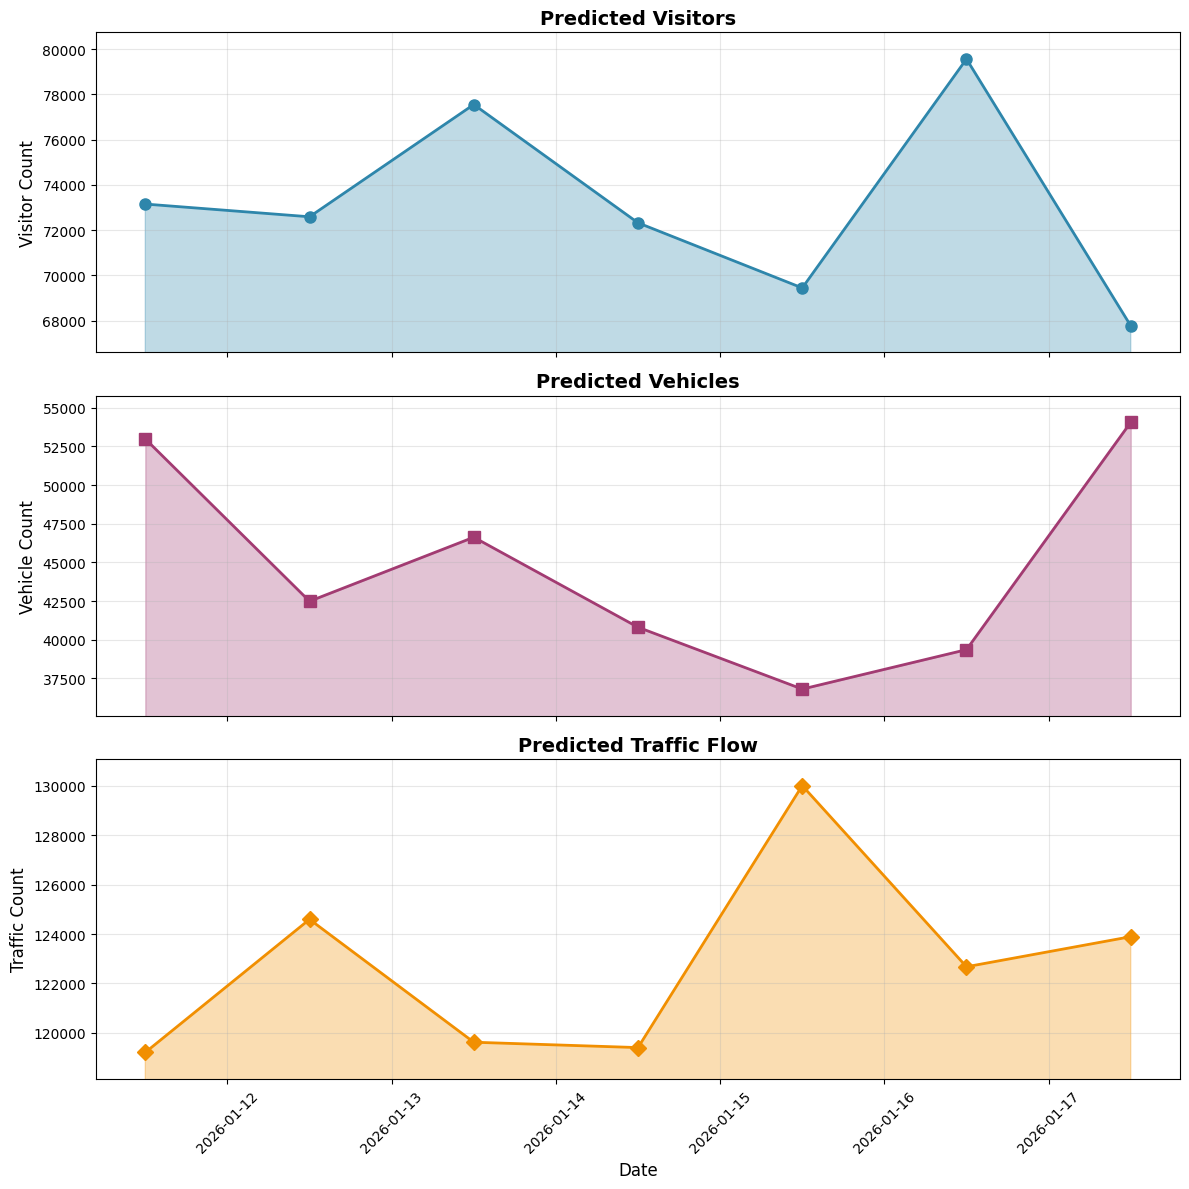


✅ Visualization complete!


In [29]:
# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Convert date back to datetime for plotting
plot_dates = pd.to_datetime(batch_data['date'])

# Plot 1: Predicted Visitors
axes[0].plot(plot_dates, batch_data['predicted_visitors'], 
             marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0].set_title('Predicted Visitors', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Visitor Count', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(plot_dates, batch_data['predicted_visitors'],
                     alpha=0.3, color='#2E86AB')
# 自动调整Y轴范围，留出10%的空白
y_min = batch_data['predicted_visitors'].min()
y_max = batch_data['predicted_visitors'].max()
y_range = y_max - y_min
axes[0].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

# Plot 2: Predicted Vehicles
axes[1].plot(plot_dates, batch_data['predicted_vehicles'],
             marker='s', linewidth=2, markersize=8, color='#A23B72')
axes[1].set_title('Predicted Vehicles', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Vehicle Count', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].fill_between(plot_dates, batch_data['predicted_vehicles'],
                     alpha=0.3, color='#A23B72')
# 自动调整Y轴范围
y_min = batch_data['predicted_vehicles'].min()
y_max = batch_data['predicted_vehicles'].max()
y_range = y_max - y_min
axes[1].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

# Plot 3: Predicted Traffic Flow
axes[2].plot(plot_dates, batch_data['predicted_traffic_count'],
             marker='D', linewidth=2, markersize=8, color='#F18F01')
axes[2].set_title('Predicted Traffic Flow', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Traffic Count', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].fill_between(plot_dates, batch_data['predicted_traffic_count'],
                     alpha=0.3, color='#F18F01')
# 自动调整Y轴范围
y_min = batch_data['predicted_traffic_count'].min()
y_max = batch_data['predicted_traffic_count'].max()
y_range = y_max - y_min
axes[2].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

# Format x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

## 9. Summary Statistics

In [30]:
print("=" * 70)
print("PREDICTION SUMMARY STATISTICS")
print("=" * 70)

summary = batch_data[['predicted_visitors', 'predicted_vehicles', 'predicted_traffic_count']].describe()
print("\n", summary)

print("\n" + "=" * 70)
print("DAILY BREAKDOWN")
print("=" * 70)

for idx, row in batch_data.iterrows():
    print(f"\n📅 {row['date']}")
    print(f"   Holiday: {'Yes' if row['holidays'] else 'No'}")
    print(f"   Temperature: {row['temperature_2m_mean']:.1f}°C")
    print(f"   Predicted Visitors: {row['predicted_visitors']:,.0f}")
    print(f"   Predicted Vehicles: {row['predicted_vehicles']:,.0f}")
    print(f"   Predicted Traffic: {row['predicted_traffic_count']:,.0f}")

PREDICTION SUMMARY STATISTICS

        predicted_visitors  predicted_vehicles  predicted_traffic_count
count            7.000000            7.000000                 7.000000
mean         73202.140625        44732.417969            122772.085938
std           4166.524414         6714.569336              3886.848633
min          67774.546875        36811.281250            119214.125000
25%          70885.750000        40084.714844            119517.152344
50%          72592.453125        42487.648438            122675.757812
75%          75354.925781        49802.810547            124241.699219
max          79566.609375        54052.964844            129997.031250

DAILY BREAKDOWN

📅 2026-01-11 12:00:00
   Holiday: Yes
   Temperature: -1.2°C
   Predicted Visitors: 73,155
   Predicted Vehicles: 52,980
   Predicted Traffic: 119,214

📅 2026-01-12 12:00:00
   Holiday: No
   Temperature: -2.0°C
   Predicted Visitors: 72,592
   Predicted Vehicles: 42,488
   Predicted Traffic: 124,592

📅 2026-0

In [32]:
from generate_dashboard import create_prediction_charts, generate_html_dashboard
import webbrowser
import os

# 创建输出目录
output_dir = './dashboard'
os.makedirs(output_dir, exist_ok=True)

# 生成图表
charts = create_prediction_charts(batch_data, output_dir=output_dir)

# 生成HTML
html_file = generate_html_dashboard(
    batch_data,
    charts,
    output_file=os.path.join(output_dir, 'traffic_dashboard.html')
)

# 自动打开
webbrowser.open('file://' + os.path.abspath(html_file))

✅ HTML dashboard generated: ./dashboard/traffic_dashboard.html


False